In [1]:
#default_exp zero_shot_learning

In [2]:
#export
from operator import itemgetter

import numpy as np
import tqdm
import bs4
import feedparser
import seaborn as sns
import pandas as pd


import torch
from pytorch_hackathon import rss_feeds

In [3]:
%cd ..

/home/kuba/Projects/pytorch_hackathon


In [4]:
#export
def get_feed_df(feed_urls):
    feeds = [
        (feed_url, feedparser.parse(feed_url))
        for feed_url in tqdm.tqdm(feed_urls)
    ]
    return pd.concat(
        [
            add_field(get_feed_article_df(feed), 'feed', feed_url)
            for (feed_url, feed) in feeds
            if len(feed['entries']) > 0
        ]
    )

In [5]:
rss_feed_urls = pd.read_table('data/feeds.txt', header=None).iloc[:,0].values

In [6]:
feed_df = rss_feeds.get_feed_df(rss_feed_urls)

100%|██████████| 16/16 [00:12<00:00,  1.30it/s]
/home/kuba/Projects/pytorch_hackathon/pytorch_hackathon/rss_feeds.py:63: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 63 of the file /home/kuba/Projects/pytorch_hackathon/pytorch_hackathon/rss_feeds.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  feed_df['text'] = feed_df['summary'].apply(lambda s: bs4.BeautifulSoup(s).text)


### Zero-shot learning

Using self-attention models from [huggingface transformers](https://github.com/huggingface/transformers) it is possible to run unsupervised text classification. This can be also viewed as (soft) clustering with side information on clusters.

This approach for zero-shot learning uses classes that are texts themselves, and leverages text embeddings to do classification.

The following code uses [ktrain](https://github.com/amaiya/ktrain) library's implementation - it uses pretrained model for Natural Language Inference to classify texts. For the details of this approach see [Zero-Shot Learning in Modern NLP](https://joeddav.github.io/blog/2020/05/29/ZSL.html) blog post.

In [ ]:
from ktrain import text 

In [7]:
zsl_clf = text.ZeroShotClassifier(device='cuda')

In [8]:
zsl_clf 

In [9]:
example_article = feed_df.iloc[0]
example_article_text = example_article['text']

In [10]:
#export
topic_strings = [
    'deep learning',
    'natural language processing',
    'computer vision',
    'statistics',
    'business intelligence',
    'visualization',
    'industry',
    'implementation',
    'software engineering',
    'reddit question',
    'science',
    'cloud computing',
    'deployment',
    'business'
]

In [11]:
topic_strings = pd.read_table('data/topics.txt', header=None).iloc[:,0].values

In [12]:
#export

def get_zero_shot_classification_results(zsl_clf, text, topic_strings, max_length=128, sort=True):
    text_length = len(text.split())
    results = zsl_clf.predict(text, topic_strings=topic_strings, include_labels=True, batch_size=len(topic_strings), max_length=min(max_length, text_length))
    if sort:
        return sorted(results, key=itemgetter(1), reverse=True)
    else:
        return results


def get_zero_shot_classification_results_df(zsl_clf, texts, topic_strings, progbar_wrapper=tqdm.tqdm):
    results_df = pd.DataFrame(np.zeros((len(texts), len(topic_strings))), columns=sorted(topic_strings))
    for i, text in enumerate(progbar_wrapper(texts)):
        results = get_zero_shot_classification_results(zsl_clf, text, topic_strings)
        results_df.iloc[i] = pd.Series(dict(sorted(results, key=itemgetter(0))))
    return results_df

In [13]:
results = get_zero_shot_classification_results(zsl_clf, example_article_text, topic_strings)
results = sorted(results, key=itemgetter(1), reverse=True)

In [14]:
pd.Series(dict(results))

statistics                     0.649326
computer vision                0.368404
business intelligence          0.273391
deep learning                  0.228862
software engineering           0.163440
visualization                  0.149282
competitions                   0.077538
natural language processing    0.069221
business                       0.043187
cloud computing                0.041225
deployment                     0.034641
arxiv                          0.010505
industry                       0.010333
reddit question                0.005926
implementation                 0.005482
dtype: float64

In [15]:
feed_df['text'].iloc[:100].to_csv('texts.csv')

In [16]:
results_df = get_zero_shot_classification_results_df(
    zsl_clf,
    feed_df['text'],
    topic_strings
)

100%|██████████| 295/295 [01:11<00:00,  4.13it/s]


In [17]:
feed_df[['title', 'text', 'feed', 'link']].reset_index().join(results_df.round(3)).to_csv('feed_topics.csv', index=False)

In [18]:
example_article[['title', 'text']]

title    Norm-in-Norm Loss with Faster Convergence and ...
text     Experiments on two relevant datasets (KonIQ-10...
Name: 0, dtype: object

In [19]:
categories = [c for c, __ in results]
scores = [score for __, score in results]

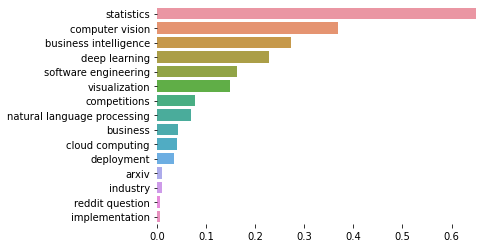

In [20]:
sns.barplot(scores, categories)
sns.despine(left=True, bottom=True)